In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from copy import deepcopy
import pandas as pd
from sklearn import preprocessing

lam = 1/500
gamma=0.5
def sm_loss(X,y,w):
    phi_z=[]
    for i in range(len(X)):
        z=y[i]*np.dot(w, X[i])
        if z>=1:
            phi_z.append(0)
        elif (1-gamma)<z<1:
            phi_z.append((1-z)**2/(2*gamma))
        else:
            phi_z.append(1-0.5*gamma-z)
        
    return np.sum(phi_z)
def objective(X,y,w, lam):
    tmp=[]
    n_samples, m_features = X.shape
    return sm_loss(X,y,w)/n_samples+lam*np.sum(np.abs(w))

def prox(z, m_features):
    w = np.zeros(m_features,dtype=float)
    for i in range(m_features):
        if z[i] > lam:
            w[i] = z[i] - lam
        elif -lam < z[i] < lam:
            w[i]= 0
        else:
            w[i] = z[i] + lam
    return w 
    
def lasso_proximal_gradient(X, y, lam, L=1, max_iter=1000,tol=0.001 ):
    beta = 0.5
    n_samples, m_features = X.shape
    w = np.empty(m_features, dtype=float)
    w_pre = np.empty(m_features,dtype=float)
    #grad_w=np.empty(m_features,dtype=float)
    prox_thres = lam/L
    h_prox_optval = np.empty(max_iter, dtype=float)
    path=[]
    for k in range(max_iter):
        los_w_tmp=[]
        w_tmp=np.zeros(m_features,dtype=float)
        for i,x in enumerate(X):
            if (y[i]*np.dot(X[i],w))>=1:
                grad_w = np.zeros(m_features,dtype=float)
            elif -0.5<(y[i]*np.dot(X[i],w))<1:
                grad_w = 2*(1-y[i]*np.dot(X[i],w))*X[i]*y[i]
            else:
                grad_w = X[i]*y[i]
            #w_tmp = np.sign(w-grad_w/L)*np.maximum(np.abs(w-grad_w/L)-prox_thres,0)
            z = w - grad_w/L
            w_tmp = prox(z, m_features)
            w_diff = w_tmp-w
            los_w_tmp.append(sm_loss(X, y, w_tmp))
            if sm_loss(X, y, w_tmp) <= sm_loss(X, y, w) + np.dot(grad_w, w_diff) + L/2 * np.sum(w_diff**2):
                break
        L = L / beta
        w_pre=deepcopy(w)
        w = deepcopy(w_tmp)
        path.append(w)
        h_prox_optval[k] = objective(X, y,w,lam)
        if k>0 and abs(h_prox_optval[k]-h_prox_optval[k-1])<tol:
            break
    return path,w, h_prox_optval[:k+1]    

def lasso_proximal_gradient_acc_ver(X, y, lam, L=1, max_iter=1000,tol=1e-4 ):
    beta = 0.5
    n_samples, m_features = X.shape
    s = [1]*max_iter
    w = np.empty(m_features, dtype=float)
    v = w
    w_pre = np.empty(m_features,dtype=float)
    #grad_w=np.empty(m_features,dtype=float)
    prox_thres = lam/L
    h_prox_optval = np.empty(max_iter, dtype=float)
    path=[]
    for k in range(max_iter):
        los_w_tmp=[]
        w_tmp=np.zeros(m_features,dtype=float)
        for i,x in enumerate(X):
            if (y[i]*np.dot(X[i],w))>=1:
                grad_w = np.zeros(m_features,dtype=float)
            elif -0.5<(y[i]*np.dot(X[i],w))<1:
                grad_w = 2*(1-X[i]*y[i]*w)*X[i]*y[i]
            else:
                grad_w = X[i]*y[i]
            #w_tmp = np.sign(v-grad_w/L)*np.maximum(np.abs(v-grad_w/L)-prox_thres,0)
            z = v - grad_w/L
            w_tmp = prox(z, m_features)
            w_diff = w_tmp-w
            los_w_tmp.append(sm_loss(X, y, w_tmp))
            if sm_loss(X, y, w_tmp) <= sm_loss(X, y, w) + np.dot(grad_w, w_diff) + L/2 * np.sum(w_diff**2):
                break
            #if objective(X, y,w_tmp,lam)<objective(X, y,w,lam):
                #break
        s[k+1]=(1+(1+4*s[k])**(1/2))/2
        v=w_tmp + ((1-s[k])/s[k+1])*(w-w_tmp)
        L = L / beta
        w_pre=deepcopy(w)
        w = deepcopy(w_tmp)
        path.append(w)
        h_prox_optval[k] = objective(X, y,w,lam)
        if k>0 and abs(h_prox_optval[k]-h_prox_optval[k-1])<tol:
            break
    return path,w, h_prox_optval[:k+1]   

In [19]:
real_dataset = pd.read_csv('Liver_patient_data',header=0)
y = real_dataset.pop('10')

In [20]:
m=round(real_dataset['9'].mean(),2)
real_dataset['9'].fillna(m, inplace=True)

In [21]:
real_dataset_normalized = preprocessing.normalize(real_dataset, norm='l2')

In [5]:
path,w, h_prox_optval=lasso_proximal_gradient(real_dataset_normalized, y, 0.1,tol=0.001 )

In [6]:
path_acc,w_acc, h_prox_optval_acc=lasso_proximal_gradient_acc_ver(real_dataset_normalized, y, 0.1,tol=0.001 )

In [9]:
w_acc

array([-0.69759306,  0.18881885,  0.10105435,  0.        ,  0.        ,
        0.        ,  0.        ,  0.081796  ,  0.32695812,  0.31932178])

In [28]:
lambd = np.arange( 0, 1, 0.01 ) 

In [29]:
non_zero_coe = []
for lam in lambd:
    path,w, h_prox_optval=lasso_proximal_gradient(real_dataset_normalized, y, lam ,tol=0.001 )
    non_zero_coe.append(np.count_nonzero(w))

In [32]:
non_zero_coe_acc = []
for lam in lambd:
    path_acc,w_acc, h_prox_optval_acc=lasso_proximal_gradient_acc_ver(real_dataset_normalized, y, lam,tol=0.001 ) 
    non_zero_coe_acc.append(np.count_nonzero(w_acc))

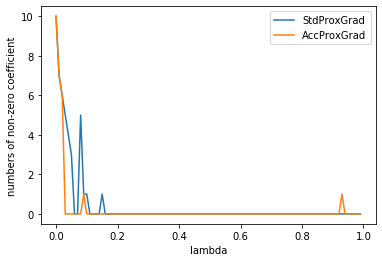

In [34]:
plt.xlabel('lambda')
plt.ylabel('numbers of non-zero coefficient')
plt.plot(lambd,non_zero_coe, label = 'StdProxGrad')
plt.plot(lambd,non_zero_coe_acc, label='AccProxGrad')
plt.legend()
plt.savefig('Non-zero coe num against lam')

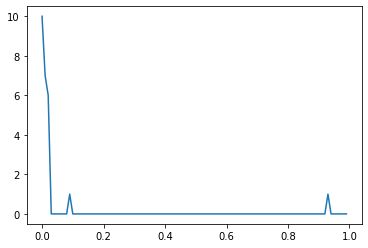

In [33]:
plt.plot(lambd,non_zero_coe_acc)

In [81]:
F_w_star = 0.75 

In [93]:
h_diff= []
for i in range(len(h_prox_optval)):
    h_diff.append(h_prox_optval[i]-F_w_star)

h_diff_acc= []
for i in range(len(h_prox_optval_acc)):
    h_diff_acc.append(h_prox_optval_acc[i]-F_w_star)
    

C:\Users\zhaoyiming\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


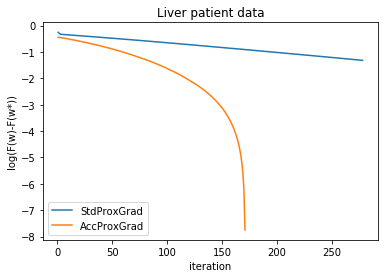

In [94]:
y=[i for i in h_diff]
x=np.arange(1,len(y)+1)
y_acc=[i for i in h_diff_acc]
x_acc=np.arange(1,len(y_acc)+1)
plt.title('Liver patient data')
plt.xlabel('iteration')
plt.ylabel('log(F(w)-F(w*))')
plt.plot(x, np.log(y),label='StdProxGrad')
plt.plot(x_acc, np.log(y_acc),label='AccProxGrad')
plt.legend()
plt.savefig('Liver_patient_training_process')